In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import time
from IPython.display import clear_output
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


In [2]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})

sns.set_style("whitegrid", {'axes.grid' : False})

## Introducing the Environment

We formalise the problem into an example classroom with rows of students and a teacher. 

The teacher is the controller of the system and would like for the paper to be passed to him/her and placed into the recycling bin, not the general trash. More formally:

1. the paper should be passed along the class, 
2. in as few steps as possible, 
3. until it can be passed to the lecturer (controller) and will be placed in the bin. 

We first show this as a real diagram and then how this can be formalised into a 'Grid World' example. In this example, students A and M are 'risky' individuals in that there is a chance that they attempt to throw the paper. As before, each student may pass or hold onto the paper (denoted by actions that go into a wall).

### Formalising the MDP

The MDP for the environment is deﬁned by: 
- States are the students, teacher and the bin with 2-d(x,y) positions in the classroom
- Actions are commands given to each state and are deﬁned by [up, down, left, right]
- The transition probability function is deﬁned by the probability each state object has for successfully following the given action.
- The reward function is simply deﬁned as +1 for reaching the positive goal, -1 for reaching the negative goal and a small negative reward (e.g. -0.04) otherwise to encourage decisions that lead to the positive goal


The probabilities are defined by:
- The next state will depend on the current [x,y] state, action and probability distribution. If a “wall” is hit (e.g. C := [2,1] and action “up”) then the next state will remain the same as the current state.
- The teacher will always follow their command.
- Other students have the probability of following the action set to 0.8 and 0.1 for every other action
- The episode ends when the paper reaches the bin.



![Real](https://i.imgur.com/nOIUKlg.png)

![GridWorld](https://i.imgur.com/WeJnqs2.png)

In [3]:
states = ['A','B','C','D','E','F','G','T','M','recycling','trash']
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

# The low-level actions the agent can make in the environment
actions = ['left','right','up','down']
rewards = [-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1,-1]

initial_policy = ['left','up','right','up','up','right','right','right','up','up','up']

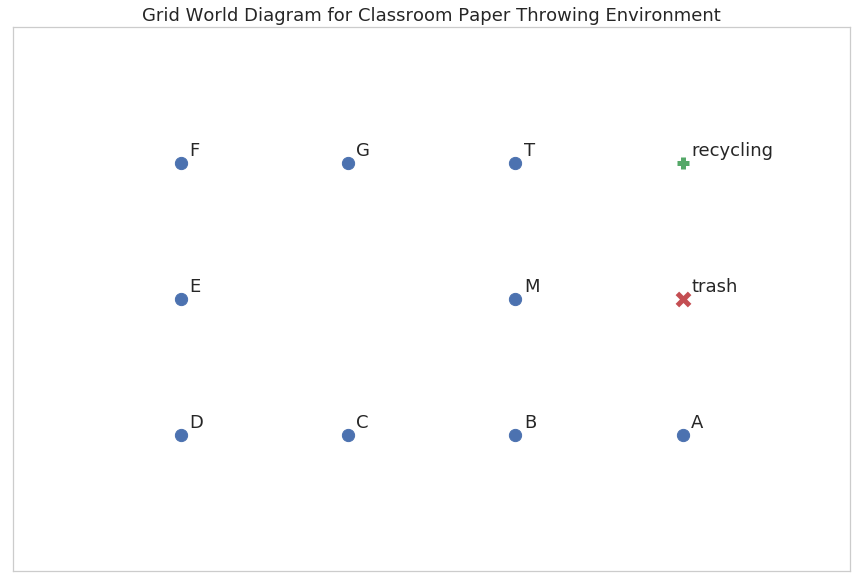

In [4]:
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
plt.title("Grid World Diagram for Classroom Paper Throwing Environment")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


In [5]:
def action_outcome(state_x,state_y,action):
    if action == 'left':
        u = -1
        v = 0
    elif action == 'right':
        u = 1
        v = 0
    elif action == 'up':
        u = 0
        v = 1
    elif action == 'down':
        u = 0
        v = -1
    else:
        print("Error: Invalid action given")
        
    # Override if action hits wall to not move
    if (state_x == 1) & (u == -1):
        u = 0
        v = v
    elif (state_x == 4) & (u == 1):
        u = 0
        v = v
    elif (state_y == 1) & (v == -1):
        u = u
        v = 0
    elif (state_y == 3) & (v == 1):
        u = u
        v = 0
    elif (state_x == 2)&(state_y == 1) & (v == 1):
        u = u
        v = 0
    elif (state_x == 1)&(state_y == 2) & (u == 1):
        u = 0
        v = v  
    elif (state_x == 2)&(state_y == 3) & (v == -1):
        u = u
        v = 0         
    elif (state_x == 3)&(state_y == 2) & (u == -1):
        u = 0
        v = v 
    # Make so it cannot get out of bin
    elif (state_x == 4)&(state_y == 3):
        u = 0
        v = 0
    elif (state_x == 4)&(state_y == 2):
        u = 0
        v = 0
    return(u,v)

In [6]:
state_action_pairs = pd.DataFrame()
for n1,state in enumerate(states):
    action_list = pd.DataFrame()
    for n2,action in enumerate(actions):
        
        state_x = x_list[n1]
        state_y = y_list[n1]
        u = action_outcome(state_x,state_y,action)[0]
        v = action_outcome(state_x,state_y,action)[1]
        action_list  = action_list.append(pd.DataFrame({'state':state,'action':action,'x':x_list[n1],'y':y_list[n1],
                                                               'u':u,'v':v}, index=[(n1*len(actions)) + n2]))
    
    state_action_pairs = state_action_pairs.append(action_list)
state_action_pairs.head()

,state,action,x,y,u,v
0,A,left,4,1,-1,0
1,A,right,4,1,0,0
2,A,up,4,1,0,1
3,A,down,4,1,0,0
4,B,left,3,1,-1,0


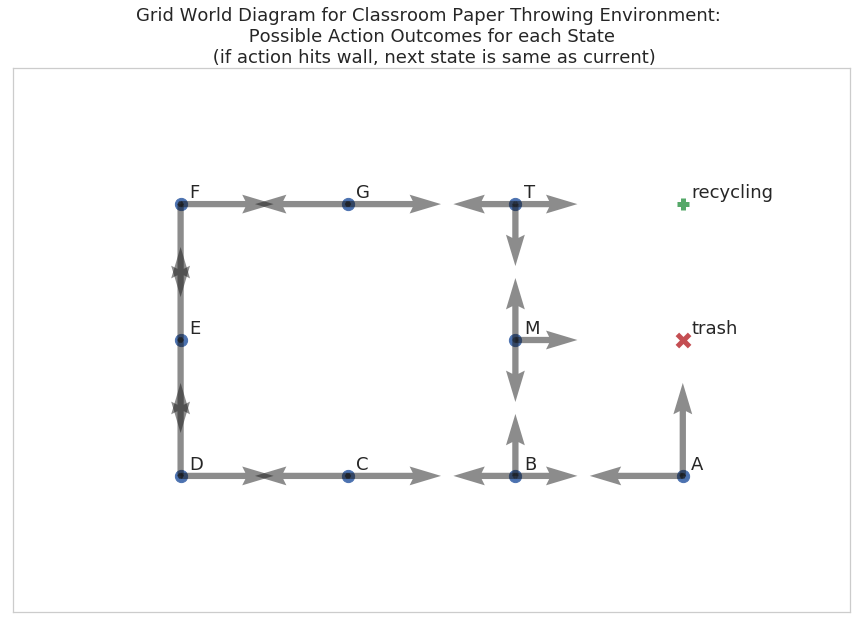

In [7]:
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    
    state_action_pairs_state = state_action_pairs[state_action_pairs['state']==state]
    plt.quiver([x_list[n],x_list[n],x_list[n],x_list[n]],[y_list[n],y_list[n],y_list[n],y_list[n]],
               state_action_pairs_state['u'],state_action_pairs_state['v'], alpha = 0.5)
    
plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Possible Action Outcomes for each State \n (if action hits wall, next state is same as current)")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


In [8]:
initial_policy_table = pd.DataFrame()

for n,state in enumerate(states):
    state_x = x_list[n]
    state_y = y_list[n]
    policy_a = initial_policy[n]
    
    u = action_outcome(state_x,state_y,policy_a)[0]
    v = action_outcome(state_x,state_y,policy_a)[1]
    
    initial_policy_table = initial_policy_table.append(pd.DataFrame({'state':state,'x':state_x,'y':state_y, 'action':policy_a,
                                                                       'u':u,'v':v}, index=[n]))
initial_policy_table

,state,x,y,action,u,v
0,A,4,1,left,-1,0
1,B,3,1,up,0,1
2,C,2,1,right,1,0
3,D,1,1,up,0,1
4,E,1,2,up,0,1
5,F,1,3,right,1,0
6,G,2,3,right,1,0
7,T,3,3,right,1,0
8,M,3,2,up,0,1
9,recycling,4,3,up,0,0


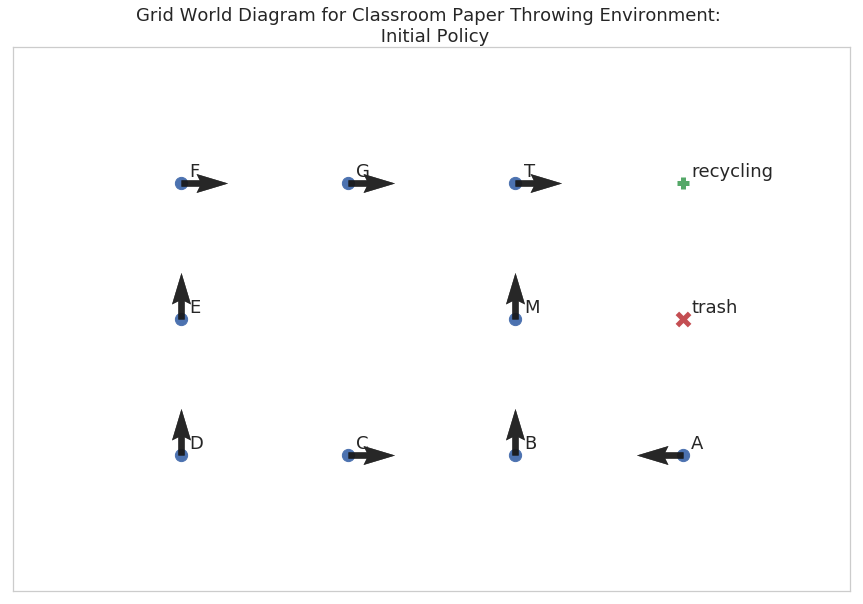

In [9]:
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    
    initial_policy_table_state = initial_policy_table[initial_policy_table['state']==state]
    plt.quiver([x_list[n],x_list[n],x_list[n],x_list[n]],[y_list[n],y_list[n],y_list[n],y_list[n]],
               initial_policy_table_state['u'],initial_policy_table_state['v'], alpha = 0.5)
    
plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Initial Policy")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


In [10]:
def environment(state, action):
    # Outcome probabilities
    if (state=='recycling')|(state=='trash'):
        prob = 0
    elif (state=='T'):
        prob = 1

    elif (state=='M'):
        prob = 0.7
   
    elif (state=='B'):
        prob = 0.7

    elif (state=='A'):
        prob = 0.7

    elif (state=='C'):
        prob = 0.7

    elif (state=='D'):
        prob = 0.7

    elif (state=='E'):
        prob = 0.7

    elif (state=='F'):
        prob = 0.7

    elif (state=='G'):
        prob = 0.7

    else:
        prob = "Error"
        print("Error state", state)

    action_rng = np.random.rand()
    if action_rng<=prob:
        action = action
    else:
        action_sub_list = actions.copy()
        action_sub_list.remove(action)
        action = random.choice(action_sub_list)
        
        
    state_x = x_list[states.index(state)]
    state_y = y_list[states.index(state)]
    u = action_outcome(state_x,state_y,action)[0]
    v = action_outcome(state_x,state_y,action)[1]
    next_state_x = state_x + u
    next_state_y = state_y + v
    # Returns index of x + y position to then find the state name
    next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]
    reward = rewards[states.index(next_state)]
    return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)

In [11]:
for i in range(0,10):
    print(environment('A', 'left'))

('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'up', 4, 1, 0, 1, 'trash', 4, 2, -1)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'right', 4, 1, 0, 0, 'A', 4, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)


In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import time
from IPython.display import clear_output
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15, 10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})

sns.set_style("whitegrid", {'axes.grid' : False})

#------------------------------------------------------------------------------------------

states = ['A','B','C','D','E','F','G','T','M','recycling','trash']
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

# The low-level actions the agent can make in the environment
actions = ['left','right','up','down']
rewards = [-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1,-1]

initial_policy = ['left','up','right','up','up','right','right','right','up','up','up']

#------------------------------------------------------------------------------------------

def action_outcome(state_x,state_y,action):
    if action == 'left':
        u = -1
        v = 0
    elif action == 'right':
        u = 1
        v = 0
    elif action == 'up':
        u = 0
        v = 1
    elif action == 'down':
        u = 0
        v = -1
    else:
        print("Error: Invalid action given")
        
    # Override if action hits wall to not move
    if (state_x == 1) & (u == -1):
        u = 0
        v = v
    elif (state_x == 4) & (u == 1):
        u = 0
        v = v
    elif (state_y == 1) & (v == -1):
        u = u
        v = 0
    elif (state_y == 3) & (v == 1):
        u = u
        v = 0
    elif (state_x == 2)&(state_y == 1) & (v == 1):
        u = u
        v = 0
    elif (state_x == 1)&(state_y == 2) & (u == 1):
        u = 0
        v = v  
    elif (state_x == 2)&(state_y == 3) & (v == -1):
        u = u
        v = 0         
    elif (state_x == 3)&(state_y == 2) & (u == -1):
        u = 0
        v = v 
    # Make so it cannot get out of bin
    elif (state_x == 4)&(state_y == 3):
        u = 0
        v = 0
    elif (state_x == 4)&(state_y == 2):
        u = 0
        v = 0
    return(u,v)

def environment(state, action):
    # Outcome probabilities
    if (state=='recycling')|(state=='trash'):
        prob = 0
    elif (state=='T'):
        prob = 1

    elif (state=='M'):
        prob = 0.7
   
    elif (state=='B'):
        prob = 0.7

    elif (state=='A'):
        prob = 0.7

    elif (state=='C'):
        prob = 0.7

    elif (state=='D'):
        prob = 0.7

    elif (state=='E'):
        prob = 0.7

    elif (state=='F'):
        prob = 0.7

    elif (state=='G'):
        prob = 0.7

    else:
        prob = "Error"
        print("Error state", state)

    action_rng = np.random.rand()
    if action_rng<=prob:
        action = action
    else:
        action_sub_list = actions.copy()
        action_sub_list.remove(action)
        action = random.choice(action_sub_list)
        
        
    state_x = x_list[states.index(state)]
    state_y = y_list[states.index(state)]
    u = action_outcome(state_x,state_y,action)[0]
    v = action_outcome(state_x,state_y,action)[1]
    next_state_x = state_x + u
    next_state_y = state_y + v
    # Returns index of x + y position to then find the state name
    next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]
    reward = rewards[states.index(next_state)]
    return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)

#------------------------------------------------------------------------------------------
